In [9]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt


(100, 200)
        0         1         2         3         4         5         6     
0  1.065477  0.341667  1.620457  0.333333  0.973868  0.733333  1.119378  \
1  2.018898  0.350000  1.063357  0.333333  5.985742  0.333333  1.492205   
2  3.812844  0.441667  0.973291  0.391667  0.982345  0.375000  1.206667   
3  0.992694  0.666667  0.919116  0.583333  1.219213  0.333333  0.904292   
4  1.111336  0.333333  0.874328  0.433333  1.070013  0.308333  0.974060   

        7          8         9    ...       190       191       192       193   
0  0.333333   1.191749  0.375000  ...  1.764640  0.333333  1.150359  0.333333  \
1  0.408333  17.772097  0.333333  ...  1.721332  0.333333  1.078496  0.383333   
2  0.525000   1.002070  0.391667  ...  1.320217  0.333333  0.978259  0.450000   
3  0.475000   2.042726  0.000000  ...  1.152177  0.333333  2.090459  0.333333   
4  0.633333   1.245026  0.333333  ...  0.967579  0.825000  2.405662  0.333333   

        194       195       196       197       198

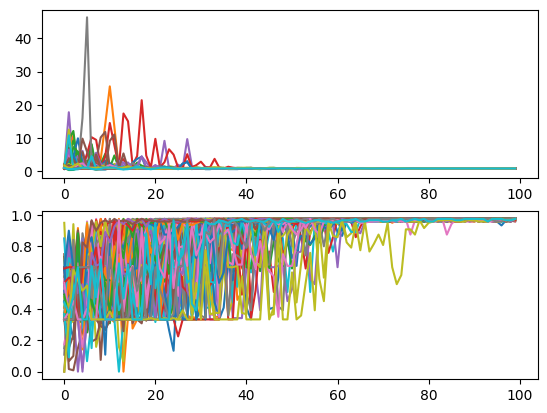

In [11]:
iris = pd.read_csv("./result/iris/05-26-07-03_100_100_0.5_1.5_0.75.csv", header=None)
print(iris.shape)
print(iris.head())

loss = []
acc = []
for i in range(len(iris.iloc[0])):
    if i % 2 == 0:
        loss.append(iris[i])
    else:
        acc.append(iris[i])

print(len(loss))
print(len(acc))

plt.subplot(2,1,1)
for i in range(len(loss)):
    plt.plot(loss[i], label=f"loss_{i}")

plt.subplot(2,1,2)
for i in range(len(acc)):
    plt.plot(acc[i], label=f"acc_{i}")


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout

import numpy as np

def make_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(5, 5), activation='relu', input_shape=(28,28,1)))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    # model.summary()

    return model

2023-05-26 03:53:32.688348: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-26 03:53:32.796903: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-26 03:53:33.196478: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvrtc.so.11.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:/usr/local/TensorRT/lib:/usr/local/cuda-11.2/lib64:/usr/local/TensorRT/lib:
2023-05-26 03:53:33.196616: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load d

In [2]:
model = make_model()
# json_ = model.to_json()
# print(json_)
# for layer in model.get_weights():
    # print(layer.shape)
weight = model.get_weights()

2023-05-26 03:53:33.924839: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-26 03:53:33.928891: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-26 03:53:33.929032: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-26 03:53:33.929450: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [16]:
from time import time
import cupy as cp

def encode(weights):
    w_gpu = cp.array([])
    lenght = []
    shape = []
    for layer in weights:
        shape.append(layer.shape)
        w_ = layer.reshape(-1)
        lenght.append(len(w_))
        w_gpu = cp.append(w_gpu, w_)
    
    return w_gpu, shape, lenght

def decode(weight, shape, lenght):
    weights = []
    start = 0
    for i in range(len(shape)):
        end = start + lenght[i]
        print(f"{start} ~ {end}")
        print(f"{shape[i]}")
        w_ = weight[start:end]
        w_ = w_.reshape(shape[i])
        weights.append(w_)
        start = end

    return weights

w = 0.8
v,_,_ = encode(weight)
c0 = 0.5
c1 = 1.5
r0 = 0.2
r1 = 0.8
p_best,_,_ = encode(weight)
g_best,_,_ = encode(weight)
layer,shape,leng = encode(weight)

# new_v = w*v[i]
# new_v = new_v + c0*r0*(p_best[i] - layer)
# new_v = new_v + c1*r1*(self.g_best[i] - layer)

start = time()
new_velocity = w * v + c0 * r0 * (p_best - layer) + c1 * r1 * (g_best - layer)

# print(new_velocity)

we2 = decode(new_velocity, shape, leng)
# print(we2)


# # s= [1,2]
# print(w)
print(leng)
print(shape)

# w2 = w
# c1 = c

# tf_start = time()
# w3 = tf.multiply(w2, w)
# tf_end = time()
# mul_start = time()
# w4 = w2 * w
# mul_end = time()
# cuda_start = time()
# w5 = c1 * c
# cuda_end = time()

# print(f"tf 연산 > {tf_end-tf_start} | {w3}")
# print(f"곱셈 연산 > {mul_end-mul_start} | {w4}")
# print(f"cuda 연산 > {cuda_end-cuda_start} | {w5}")

# for i in range(len(w)):
#     if w[i] != w2[i]:
#         print("not same")
#         break
#     else:
#         print("same")



0 ~ 800
(5, 5, 1, 32)
800 ~ 832
(32,)
832 ~ 19264
(3, 3, 32, 64)
19264 ~ 19328
(64,)
19328 ~ 93056
(576, 128)
93056 ~ 93184
(128,)
93184 ~ 94464
(128, 10)
94464 ~ 94474
(10,)
[800, 32, 18432, 64, 73728, 128, 1280, 10]
[(5, 5, 1, 32), (32,), (3, 3, 32, 64), (64,), (576, 128), (128,), (128, 10), (10,)]
